In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.colors import LogNorm
from numpy import pi, cos,sin
import os
import re
import urllib.request
from astropy.time import Time

D_003=132.2 # luminsity distance for z=0.03 this can also come from astropy
folderdata='/scratch/garzilli/data/'
folderobj = os.path.join(folderdata,'dr16/eboss/photoObj/301/')

MODE=1 # only primary
# MODE=2 # only secondary

In [2]:
import sys
import astroquery
print(astroquery.__path__)
from astroquery.simbad import Simbad 
from astroquery import sdss

['/home/astro/garzilli/local/lib/python3.7/site-packages/astroquery-0.4.2.dev6620-py3.7.egg/astroquery']


In [3]:
from astroquery import sdss

In [4]:
result_table = Simbad.query_object("Mrk5", wildcard=True)

In [12]:
print(result_table.dtype)
print(result_table['RA'])
ra = result_table['RA'].data[0]
dec = result_table['DEC'].data[0]
print(ra)
ra_degree=ra.split(' ')[0]  + '°' + ra.split(' ')[1] + '′' + ra.split(' ')[2] + '″'
print(ra_degree)
print(Angle(ra_degree).arcmin)
print(dec)
dec_degree=dec.split(' ')[0]  + '°' + dec.split(' ')[1] + '′' + dec.split(' ')[2] + '″'
print(dec_degree)
print(Angle(dec_degree).arcmin)


[('MAIN_ID', 'O'), ('RA', '<U13'), ('DEC', '<U13'), ('RA_PREC', '<i2'), ('DEC_PREC', '<i2'), ('COO_ERR_MAJA', '<f4'), ('COO_ERR_MINA', '<f4'), ('COO_ERR_ANGLE', '<i2'), ('COO_QUAL', '<U1'), ('COO_WAVELENGTH', '<U1'), ('COO_BIBCODE', 'O')]
    RA    
 "h:m:s"  
----------
06 42 15.9
06 42 15.9
06°42′15.9″
402.265
+75 37 40
+75°37′40″
4537.666666666666


In [13]:
co = SkyCoord(ra_degree+' '+dec_degree)
print(co)
#co = SkyCoord(Angle(ra_degree).degree,Angle(dec_degree).degree, unit='deg')
#print(co)
coordinate='0h8m05.63s +14d50m23.3s'
co = SkyCoord(coordinate)
radius = Angle(2, unit='arcmin')


query1 = sdss.SDSS.query_region(co, radius=radius,data_release=16, 
                                photoobj_fields=['run', 'rerun','camcol','field','ra','dec','mode',
                                                 'petroFlux_u', 'petroFlux_g', 'petroFlux_r','petroFlux_i','petroFlux_z',
                                                 'TAI_u', 'TAI_g', 'TAI_r', 'TAI_i', 'TAI_z','objID'])
print(query1[:5])
print(len(query1))
query={}
for k in query1.keys():
    query[k]=query1[k].data
    

<SkyCoord (ICRS): (ra, dec) in deg
    (6.70441667, 75.62777778)>
run  rerun camcol ...      TAI_i            TAI_z              objID       
---- ----- ------ ... ---------------- ---------------- -------------------
1043   301      3 ...  4446601524.6539 4446601668.05923 1237649953859175287
1043   301      3 ... 4446601524.50022 4446601667.93843 1237649953859175314
1739   301      3 ... 4476758677.53613 4476758820.93709 1237652943176139756
1904   301      3 ... 4482278033.48202 4482278176.90448 1237653651835782137
1904   301      3 ... 4482278033.64739 4482278177.07344 1237653651835782138
533


In [14]:
mode1_index=np.where(query['mode']==1)[0]
mode1={}
for k in query.keys():
    mode1[k]=query[k][mode1_index]
#print(mode1_index)
print('mode1:'+'{:d}'.format(len(mode1['ra'])))

mode2_index=np.where(query['mode']==2)[0]
mode2={}
for k in query.keys():
    mode2[k]=query[k][mode2_index]
#print(mode2_index)
print('mode2:'+'{:d}'.format(len(mode2['ra'])))

mode3_index=np.where(query['mode']==3)[0]
mode3={}
for k in query.keys():
    mode3[k]=query[k][mode3_index]
#print(mode3_index)
print('mode3:'+'{:d}'.format(len(mode3['ra'])))

mode4_index=np.where(query['mode']==4)[0]
mode4={}
for k in query.keys():
    mode4[k]=query[k][mode4_index]
#print(mode4_index)
print('mode4:'+'{:d}'.format(len(mode4['ra'])))

print(len(mode1['ra'])+len(mode2['ra'])+len(mode3['ra'])+len(mode4['ra']))

mode1:95
mode2:208
mode3:92
mode4:138
533


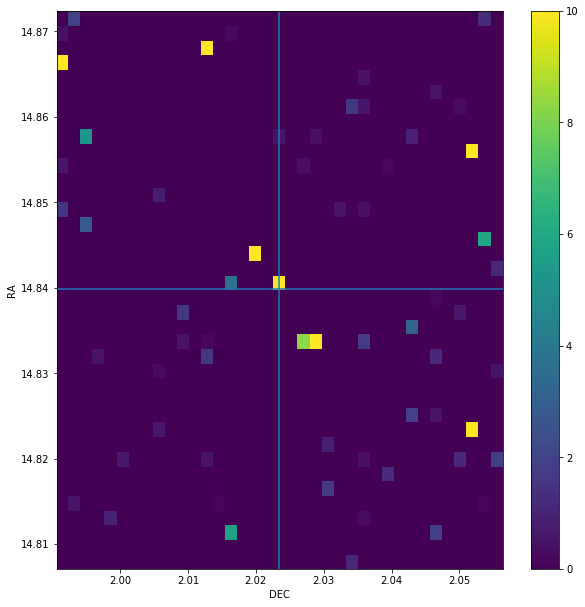

In [16]:
def pplot(rresult, primary=True):
    dec_min=min(rresult['dec'])
    dec_max=max(rresult['dec'])
    ra_min=min(rresult['ra'])
    ra_max=max(rresult['ra'])

    pix_size = 1/60./10. # say, one arcmin
    dec_mid  = (dec_min + dec_max) / 2.
    Nra      = int((ra_max - ra_min) * cos(dec_mid * pi / 180.) / pix_size)
    Ndec     = int((dec_max - dec_min) / pix_size)
    ra_b     = np.linspace(ra_min, ra_max, Nra)
    dec_b    = np.linspace(dec_min, dec_max, Ndec)


    fig = plt.figure(figsize=(10.,10.*(Ndec / Nra)))
    if primary:
        mode=np.where(rresult['mode']==1)[0]
    else:
        mode = np.range(len(rresult['mode']))
    plt.hist2d(rresult['ra'][mode], rresult['dec'][mode], bins=([ra_b, dec_b]), weights=rresult['petroFlux_u'][mode], vmax=10, vmin=0)
    plt.colorbar()
    plt.axhline(Angle(coordinate.split(' ')[1],unit='deg').deg)# dec
    plt.axvline(Angle(coordinate.split(' ')[0],unit='deg').deg)# ra
    plt.xlabel('DEC')
    plt.ylabel('RA')
    return

pplot(query)

In [17]:
filters={'u':3543, 'g':4770, 'r': 6231,'i':7625,'z':9134}

nano_maggies_to_Jy = 3631 * 10**-9 # constant of conversion

# Wavelength (Angstroms)
# Ultraviolet (u) 3543
# Green (g) 4770
# Red (r) 6231
# Near Infrared (i) 7625
# Infrared (z) 9134

[3543 4770 6231 7625 9134]
[3.09235204e-06 2.54958072e-06 6.18356032e-06 8.86018102e-06
 4.74273232e-05]


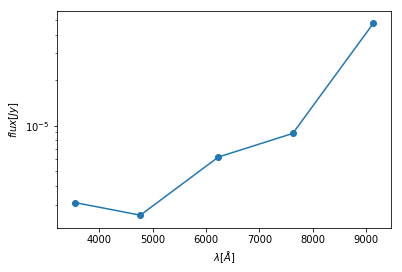

In [18]:
plt.figure()
index = 15
label=['u','g','r','i','z']
x = np.array([filters[i] for i in label])
y1 = np.array([query['petroFlux_'+i][index] for i in label]) # in nanomaggies
y = y1 * nano_maggies_to_Jy # in Jy
plt.semilogy(x, y)
plt.scatter(x,y)
plt.xlabel('$\lambda[\AA]$')
plt.ylabel('$flux[Jy]$')
print(x)
print(y)

{'u': array([4.44609009e+09]), 'g': array([4.44609023e+09]), 'r': array([4.44608995e+09]), 'i': array([4.44609002e+09]), 'z': array([4.44609016e+09])}
{'u': array([0.00033952]), 'g': array([0.00125721]), 'r': array([0.00242644]), 'i': array([0.00352887]), 'z': array([0.00465913])}


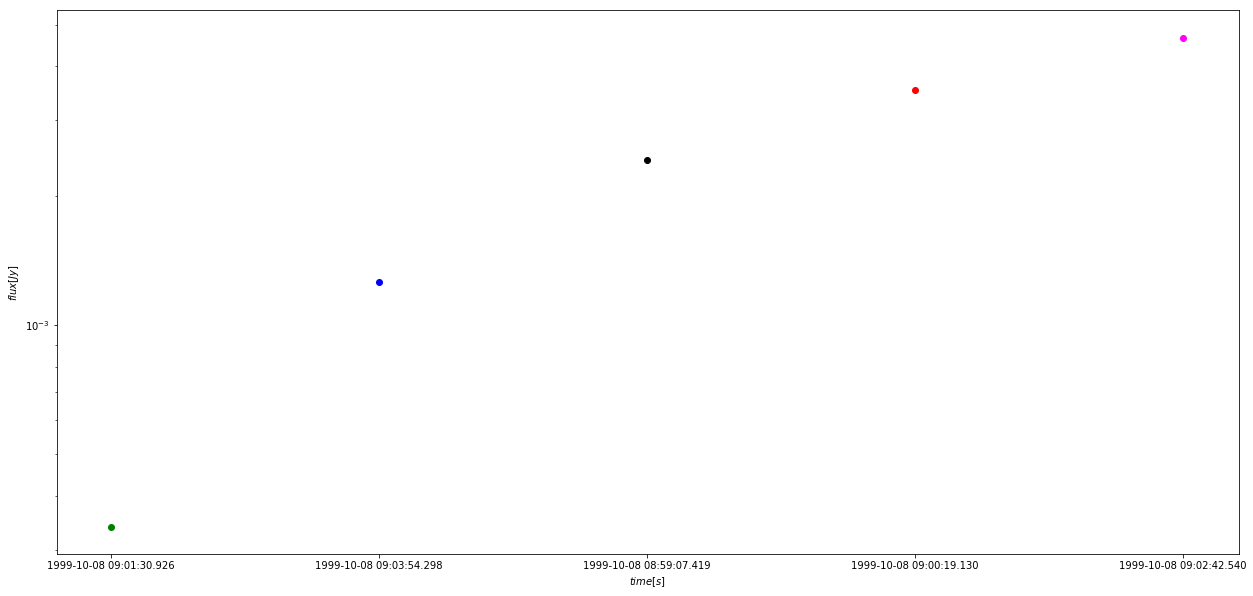

In [57]:
def MJD(t): # Modified Julian Date format
    return t/(24*3600)
source=SkyCoord(coordinate,unit='deg')
sep=np.array([])
for i in range(len(query['ra'])):
    sep=np.append(sep,source.separation(SkyCoord(query['ra'][i],query['dec'][i], unit='deg')))
i_min=[np.argmin(sep),]

plt.figure(figsize=(10.*(1.+np.sqrt(5.)*0.5),10.))
label=['u','g','r','i','z']
colors=['green', 'blue','black','red','magenta']
x = {}
y= {}
for ii in i_min:
    for lab in label:
        try:
            x[lab] = np.concatenate(x[lab], query['TAI_'+lab][ii])
            y[lab] = np.concatenate(y[lab], query['petroFlux_'+lab][ii])*nano_maggies_to_Jy
        except KeyError:
            x[lab] = np.array([query['TAI_'+lab][ii],])
            y[lab] = np.array([query['petroFlux_'+lab][ii],])*nano_maggies_to_Jy
plt.semilogy([], [],data=None)
for i,lab in enumerate(label):
    t=Time(MJD(x[lab]), format='mjd')
    t.format = 'iso'
    t.out_subfmt = 'date_hms'
    plt.scatter(t.value, y[lab],color=colors[i])
    # plt.scatter(MJD(x[lab]), y[lab],color=colors[i])
    plt.xlabel('$time[s]$')
    plt.ylabel('$flux[Jy]$')
print(x)
print(y)

In [27]:
def objid_extract(obj_id):
    masks={'sky_version':0x7800000000000000,
           'rerun':0x07FF000000000000,
           'run':0x0000FFFF00000000,
           'camcol':0x00000000E0000000,
           'first_field':0x0000000010000000,
           'field':0x000000000FFF0000,
           'id':0x000000000000FFFF}

    run=(obj_id & masks['run']) >> 32
    rerun=(obj_id & masks['rerun']) >> 48
    camcol=(obj_id & masks['camcol']) >> 29
    field=(obj_id & masks['field']) >> 16
    id=(obj_id & masks['id']) >> 0
    sky_version=(obj_id & masks['sky_version']) >> 59
    first_field=(obj_id & masks['first_field']) >> 28

    return {'run':run,
            'rerun':rerun,
            'camcol':camcol,
            'field':field,
            'id':id,
            'first_field':first_field,
            'sky_version':sky_version}

print(objid_extract(query['objID'][i_min[0]]))
print('ra = ' + '{:.3f}'.format(query['ra'][i_min[0]]))
print('dec = ' + '{:.3f}'.format(query['dec'][i_min[0]]))


{'run': 1011, 'rerun': 301, 'camcol': 3, 'field': 44, 'id': 124, 'first_field': 0, 'sky_version': 2}
ra = 2.023
dec = 14.840


In [50]:

t=Time(MJD(x['u']), format='mjd')
print(t.value)
t.format = 'iso'
t.out_subfmt = 'date_hms'
print(t.value)

[51459.37605238]
['1999-10-08 09:01:30.926']
